In [1]:
# THis is some preliminary analysis - for a neat version of this notebook (run on lots of samples)
# go to frequency_spectrum_cleaned !


from Bio import SeqIO
from Bio import pairwise2
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
RATIO="0"
REP="1"
CONC="high"
CONTROL="15"

In [3]:
genomes = list(SeqIO.parse("../data/controls12_15.fasta", format="fasta"))
wuhan_reference = SeqIO.read("../data/MN908947.3.fasta", format="fasta")

In [4]:
control12, control15 = genomes[0], genomes[1]
if CONTROL == "12":
    ref_genome = control12
elif CONTROL == "15":
    ref_genome = control15
else:
    ref_genome = wuhan_reference

In [5]:
#for i in range(30):
#    alignments = pairwise2.align.globalxs(control12.seq[i*1000:(i+1)*1000], control15.seq[i*1000:(i+1)*1000], -6., -1.)
#    print(pairwise2.format_alignment(*alignments[0]))

In [6]:
artic = pd.read_csv(
    "/home/will/Desktop/projects/embl/sars-cov-2-metagenomics-simulator/data/protocols/artic_v3_nCoV-2019.primer.bed", 
    sep="\t", header=None, names=["genome","start","end","name"], usecols=[i for i in range(4)])

def add_cols(df):
    # split the column "name" to extract useful data
    df["amplicon_number"] = df["name"].apply(lambda x: int(x.split("_")[1]))
    df["handedness"] = df["name"].apply(lambda x: x.split("_")[2])
    df["is_alt"] = df["name"].apply(lambda x: len(x.split("_")) > 3)
    df = pd.merge(
        df.loc[df["handedness"] == "LEFT"], 
        df.loc[df["handedness"] == "RIGHT"], 
        on=["amplicon_number"]
    )

    df = pd.DataFrame(df[["genome_x", "amplicon_number", "is_alt_x", "is_alt_y", "start_x", "end_x",  "start_y", "end_y"]])
    df["left_sequence"] = df.apply(lambda x: str(wuhan_reference.seq[x.start_x:x.end_x]), axis=1)
    df["right_sequence"] = df.apply(lambda x: str(wuhan_reference.seq[x.start_y:x.end_y]), axis=1)
    
    return df

def align_primers(new_reference, primer_dataframe):
    new_dataframe = pd.DataFrame(primer_dataframe[["genome_x", "amplicon_number", "is_alt_x", "is_alt_y"]])
    start_x, start_y, end_x, end_y = [], [], [], []
    
    l = len(new_reference.seq)
    
    for r in primer_dataframe.itertuples():
        
        left_end = max(0, r.start_x-200)
        right_end = min(r.start_x+200, l)
        alignments = pairwise2.align.localxs(new_reference.seq[left_end:right_end], r.left_sequence, -6., -1.)
        a = alignments[0]
        s = a.start
        start = left_end + s + 1
        end = start + len(r.left_sequence)
        start_x.append(start)
        end_x.append(end)
        
        left_end = max(0, r.start_y-200)
        right_end = min(r.start_y+200, l)
        alignments = pairwise2.align.localxs(new_reference.seq[left_end:right_end], r.right_sequence, -6., -1.)
        a = alignments[0]
        s = a.start
        start = left_end + s + 1
        end = start + len(r.left_sequence)
        start_y.append(start)
        end_y.append(end)
    
    new_dataframe["start_x"] = start_x
    new_dataframe["end_x"] = end_x
    new_dataframe["start_y"] = start_y
    new_dataframe["end_y"] = end_y
    new_dataframe["left_sequence"] = new_dataframe.apply(lambda x: str(new_reference.seq[x.start_x - 1:x.end_x - 1]), axis=1)
    new_dataframe["right_sequence"] = new_dataframe.apply(lambda x: str(new_reference.seq[x.start_y - 1:x.end_y - 1]), axis=1)
    
    return new_dataframe

artic = add_cols(artic)

ref_primers = align_primers(ref_genome, artic)

primer_starts = sorted([x.start_x for x in ref_primers.itertuples()] + [x.start_y for x in ref_primers.itertuples()])
primer_ends = sorted([x.end_x for x in ref_primers.itertuples()] + [x.end_y for x in ref_primers.itertuples()])

In [7]:
orfs = pd.read_csv("../data/sars-cov-2-orfs.tsv", delim_whitespace=True, header=None, names=["name", "start", "end"])
orfs["start_mod_3"] = orfs["start"] % 3
orfs["end_mod_3"] = orfs["end"] % 3
orfs["length"] = (orfs["end"] - orfs["start"] + 1) // 3
orfs["start_seq"] = orfs.apply(lambda x: str(wuhan_reference.seq[x.start-1:x.start+19]), axis=1)
orfs["end_seq"] = orfs.apply(lambda x: str(wuhan_reference.seq[x.end-20:x.end]), axis=1)


def align_orfs(new_reference, orf_dataframe):
    """
    Use the orf_dataframe which is the dataframe for orf starts/end positions for the wuhan reference (above).
    Give it a new reference genome. 
    Get out the corresponding dataframe for the new reference. 
    """
    new_dataframe = pd.DataFrame(orf_dataframe["name"])
    starts, ends, start_seqs, end_seqs = [], [], [], []
    
    l = len(new_reference.seq)
    
    for r in orf_dataframe.itertuples():
        left_end = max(0, r.start-500)
        right_end = min(r.start+500, l)
        alignments = pairwise2.align.localxs(new_reference.seq[left_end:right_end], r.start_seq, -6., -1.)
        a = alignments[0]
        s = a.start
        start = left_end + s + 1
        start_seq = a.seqA[s:s+20]
        
        left_end = max(0, r.end-500)
        right_end = min(r.end+500, l)
        alignments = pairwise2.align.localxs(new_reference.seq[left_end:right_end], r.end_seq, -6., -1.)
        a = alignments[0]
        s = a.start
        end = left_end + s + 20
        end_seq = a.seqA[s:s+20]
        
        starts.append(start)
        ends.append(end)
        start_seqs.append(start_seq)
        end_seqs.append(end_seq)
        
    new_dataframe["start"] = starts
    new_dataframe["end"] = ends
    new_dataframe["start_mod_3"] = new_dataframe["start"] % 3
    new_dataframe["end_mod_3"] = new_dataframe["end"] % 3
    new_dataframe["length"] = (new_dataframe["end"] - new_dataframe["start"] + 1) // 3
    new_dataframe["start_seq"] = start_seqs
    new_dataframe["end_seq"] = end_seqs
    
    return new_dataframe


def frame_lookup(position, orf_starts, orf_ends, orf_frames):
    
    if position < orf_starts[0]:
        return 1
    
    for i, start in enumerate(orf_starts):
        if start > position:
            break
    
    if position <= orf_ends[i-1]:
        return -1 * (int(position - orf_frames[i-1]) % 3)
    
    else:
        return 1

def is_stop_codon(position, mutation, reference, orf_starts, orf_ends, orf_frames):
    
    frame = frame_lookup(position, orf_starts, orf_ends, orf_frames)
    
    # if the position is non-coding then it's not a stop codon
    if frame == 1:
        return False
    
    codon = list(reference.seq[position+frame-1:position+frame+2])
    codon[-1 * frame] = mutation
    codon = "".join(codon)
    return (codon in ["TAG", "TAA", "TGA"])


def in_site(position, starts, ends):
    
    assert(len(starts) == len(ends))
    
    if position < starts[0]:
        return False
    
    for i, start in enumerate(starts):
        if start > position:
            break
    
    return (position <= ends[i-1])

ref_orfs = align_orfs(ref_genome, orfs)

ref_orf_starts = [x.start for x in ref_orfs.itertuples() if x.name != "N"]
assert(ref_orf_starts == sorted(ref_orf_starts))
ref_orf_ends = [x.end for x in ref_orfs.itertuples() if x.name != "N"]
assert(ref_orf_ends == sorted(ref_orf_ends))
ref_orf_frames = [x.start_mod_3 for x in ref_orfs.itertuples() if x.name != "N"]



In [8]:
glob.glob(f"../data/ww_dump/plate_validation/A{RATIO}_rep{REP}_{CONC}conc/*")
df = pd.read_csv(f'../data/ww_dump/plate_validation/A{RATIO}_rep{REP}_{CONC}conc/A{RATIO}_rep{REP}_{CONC}conc_c{CONTROL}.vcf', sep="\t", skiprows=22)
#df = pd.read_csv(f'../data/ww_dump/plate_validation/Ldn_110121_rep1/Ldn_110121_rep1.vcf', sep="\t", skiprows=22)

df['DEPTH'] = df['INFO'].apply(lambda x: (0 if x.split(";")[0].split("=")[-1] == "INDEL" else int(x.split(";")[0].split("=")[-1])))
df['COUNTS'] = df['INFO'].apply(lambda x: [int(y) for y in x.split(";")[1].split("=")[-1].split(",")])
df['ALTS'] = df['ALT'].apply(lambda x: x.split(','))
df['ALT_COUNTS'] = df['COUNTS'].apply(lambda x: sum(x[1:]))
df['ERROR_PC'] = df['ALT_COUNTS']/df['DEPTH']
df['ALLELES'] = df.apply(lambda x: (x.REF + "," + x.ALT).split(","), axis=1)
df['ALLELES_DICT'] = df.apply(lambda x: dict(zip(x.ALLELES, x.COUNTS)), axis=1)
df['MUT_TO_A'] = df.apply(lambda x: 0 if x.REF == 'A' or not 'A' in x.ALLELES_DICT else x.ALLELES_DICT['A'], axis=1)
df['MUT_TO_C'] = df.apply(lambda x: 0 if x.REF == 'C' or not 'C' in x.ALLELES_DICT else x.ALLELES_DICT['C'], axis=1)
df['MUT_TO_G'] = df.apply(lambda x: 0 if x.REF == 'G' or not 'G' in x.ALLELES_DICT else x.ALLELES_DICT['G'], axis=1)
df['MUT_TO_T'] = df.apply(lambda x: 0 if x.REF == 'T' or not 'T' in x.ALLELES_DICT else x.ALLELES_DICT['T'], axis=1)

df = pd.DataFrame(df[['#CHROM','POS', 'REF', 'DEPTH', 'MUT_TO_A', 'MUT_TO_C', 'MUT_TO_G', 'MUT_TO_T', 'ERROR_PC', 'ALT_COUNTS']])
df.head(5)

,#CHROM,POS,REF,DEPTH,MUT_TO_A,MUT_TO_C,MUT_TO_G,MUT_TO_T,ERROR_PC,ALT_COUNTS
0,hCoV-19/England/MILK-9E05B3/2020,240,A,1,0,0,0,0,0.0,0
1,hCoV-19/England/MILK-9E05B3/2020,241,G,1,0,0,0,0,0.0,0
2,hCoV-19/England/MILK-9E05B3/2020,242,A,1,0,0,0,0,0.0,0
3,hCoV-19/England/MILK-9E05B3/2020,243,A,1,0,0,0,0,0.0,0
4,hCoV-19/England/MILK-9E05B3/2020,244,A,1,0,0,0,0,0.0,0


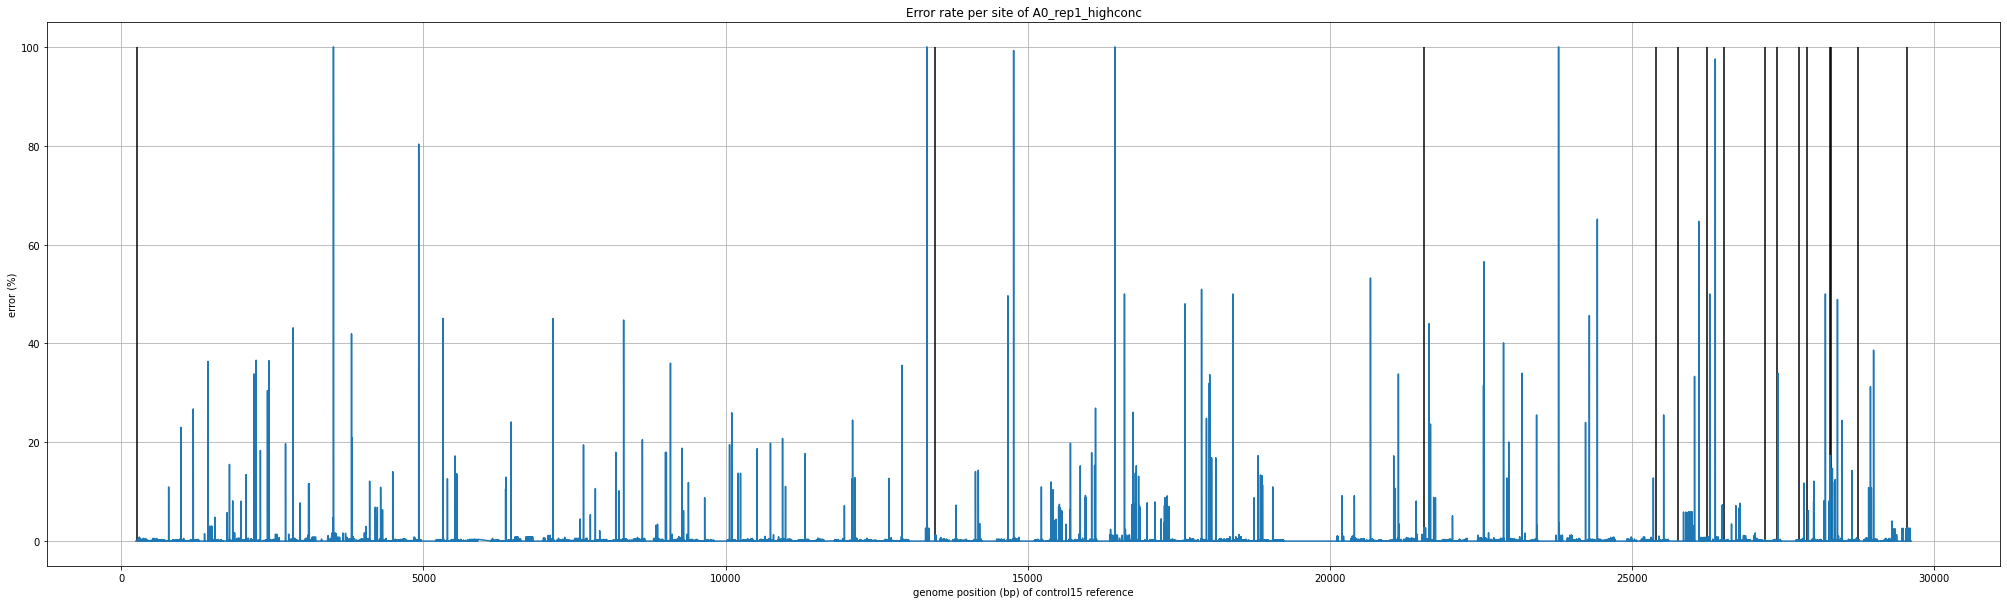

In [9]:
plt.figure(figsize=(35, 10))
plt.plot(df["POS"], 100*df["ALT_COUNTS"]/df["DEPTH"].apply(lambda x: (x if x > 5 else 10000000)))
#plt.vlines(ref_primers["start_x"], ymin=0, ymax=100, color="red")
#plt.vlines(ref_primers["end_x"], ymin=0, ymax=100, color="black")
#plt.vlines(ref_primers["start_y"], ymin=0, ymax=100, color="red")
#plt.vlines(ref_primers["end_y"], ymin=0, ymax=100, color="black")

plt.vlines(orfs["start"], ymin=0, ymax=100, color="black")

plt.title(f"Error rate per site of A{RATIO}_rep{REP}_{CONC}conc")
plt.xlabel(f"genome position (bp) of control{CONTROL} reference")
plt.ylabel("error (%)")
plt.grid()

# Plot of error rate (%) vs genome coordinate. Sites with a depth of < 5 are ignored

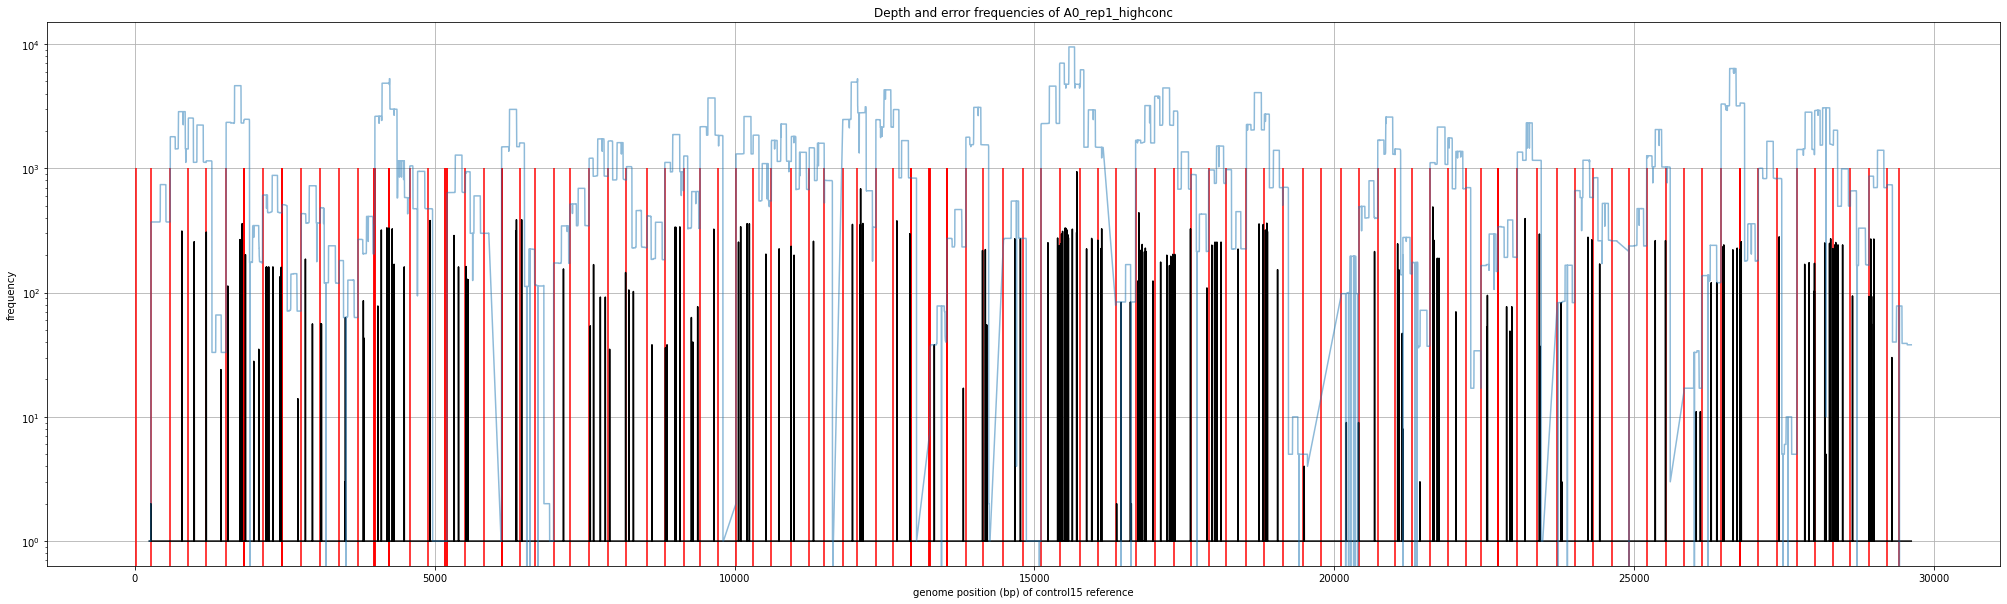

In [10]:
plt.figure(figsize=(35, 10))
plt.plot(df["POS"], df.apply(lambda x: x.ALT_COUNTS if x.ALT_COUNTS/(x.DEPTH + 0.001) > 0.02 else 1, axis=1), color="black")

plt.plot(df["POS"], df["DEPTH"], alpha=0.5)
plt.title(f"Depth and error frequencies of A{RATIO}_rep{REP}_{CONC}conc")
plt.vlines(ref_primers["start_x"], ymin=0, ymax=1000, color="red")
plt.xlabel(f"genome position (bp) of control{CONTROL} reference")
plt.ylabel("frequency")
plt.yscale('log')
plt.grid()

# Plot of depth and error count vs genome coordinate - only coordinates with > 2% error rate are shown

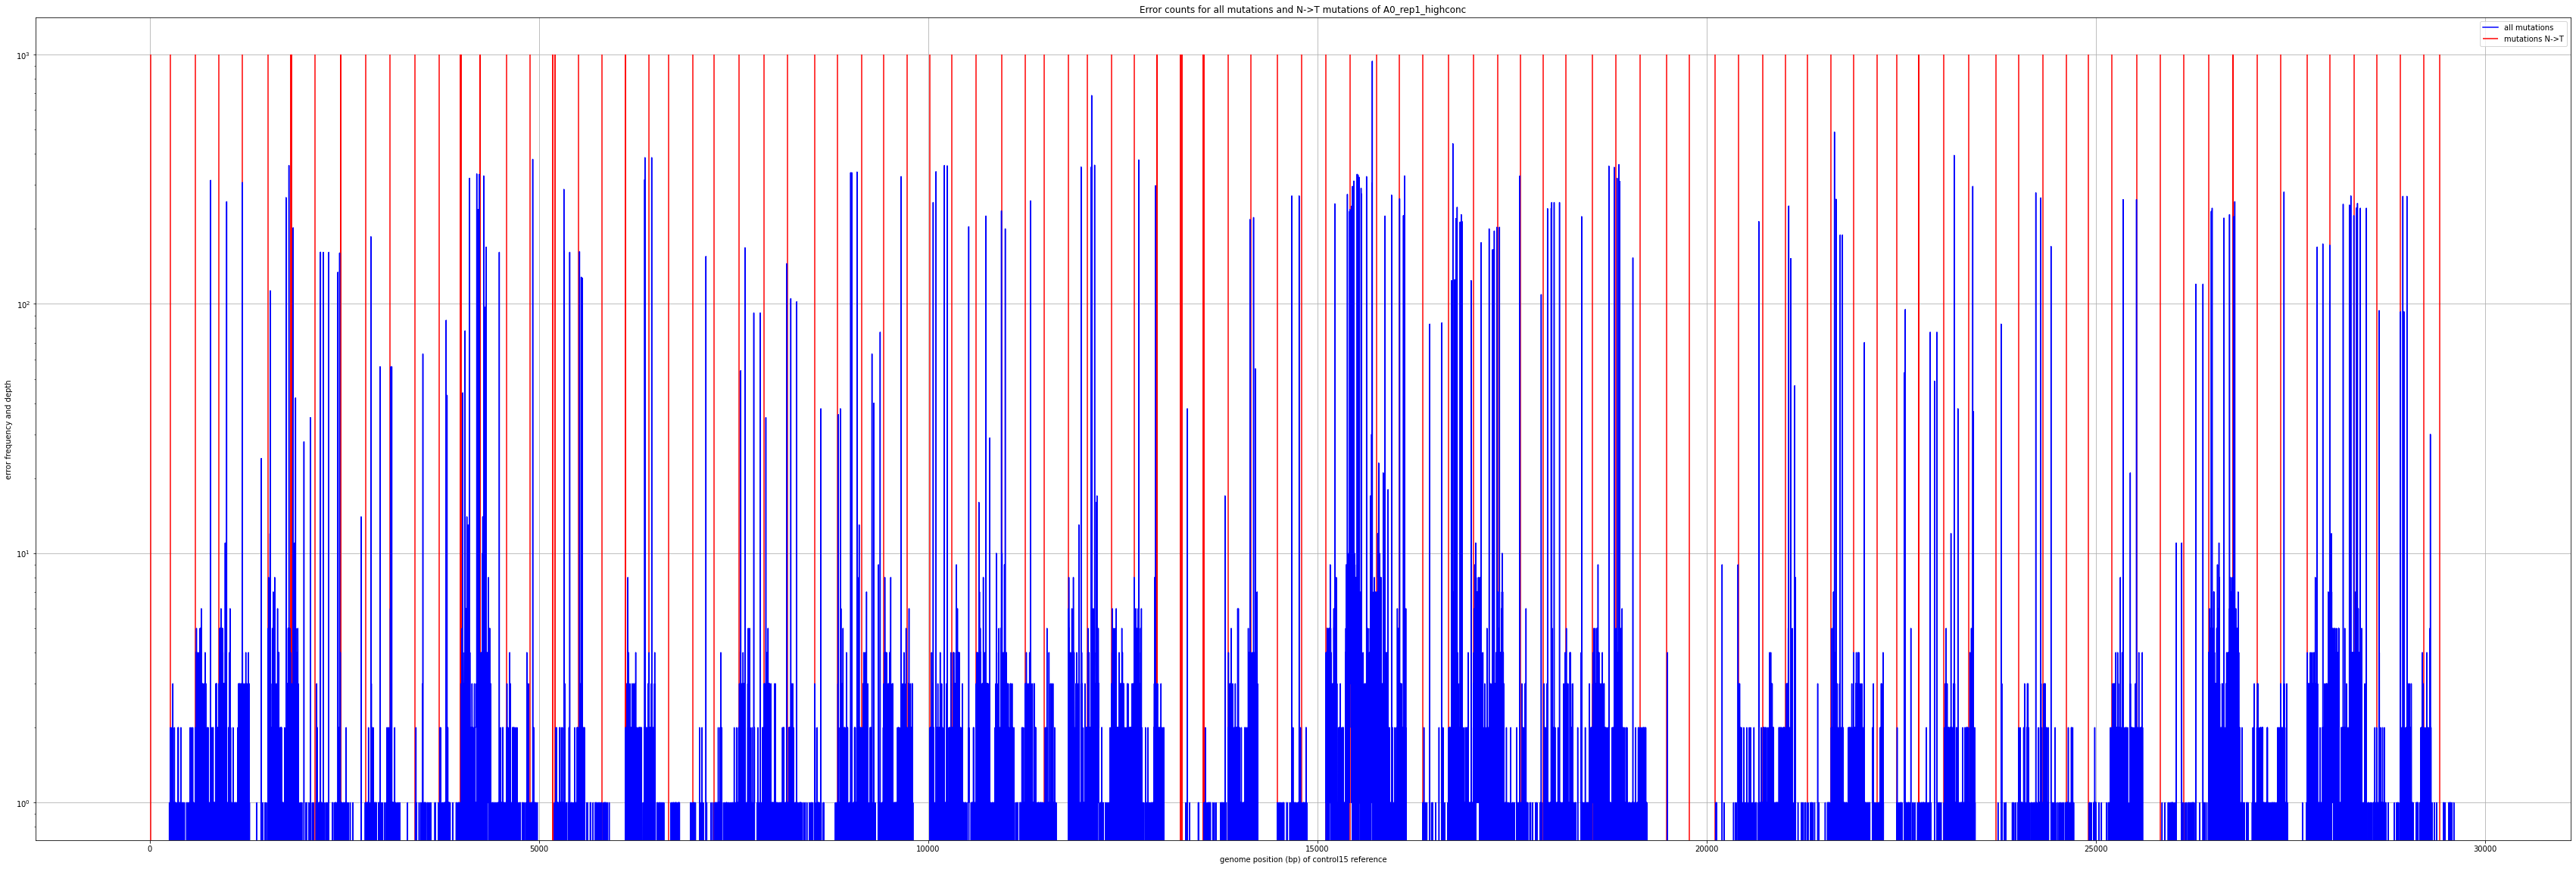

In [11]:
plt.figure(figsize=(60, 20))
plt.plot(df["POS"], df["ALT_COUNTS"], color="blue")
#plt.plot(df["POS"], df["MUT_TO_T"], color="blue")
#plt.plot(df["POS"], df["MUT_TO_A"], color="orange")
#plt.plot(df["POS"], df["MUT_TO_C"], color="red")
#plt.plot(df["POS"], df["MUT_TO_G"], color="green")


#i += 1
#plt.xlim(i*1000, (i+1)*1000)

#plt.plot(df["POS"], df["DEPTH"], alpha=0.5)
plt.vlines(ref_primers["start_x"], ymin=0, ymax=1000, color="red")
#plt.vlines(ref_primers["end_x"], ymin=0, ymax=1000, color="red")
#plt.vlines(ref_primers["start_y"], ymin=0, ymax=1000, color="red")
#plt.vlines(ref_primers["end_y"], ymin=0, ymax=1000, color="red")

plt.title(f"Error counts for all mutations and N->T mutations of A{RATIO}_rep{REP}_{CONC}conc")
plt.xlabel(f"genome position (bp) of control{CONTROL} reference")
plt.ylabel("error frequency and depth")
plt.yscale('log')
plt.grid()
plt.legend(["all mutations", "mutations N->T", "primer starts/ends"])

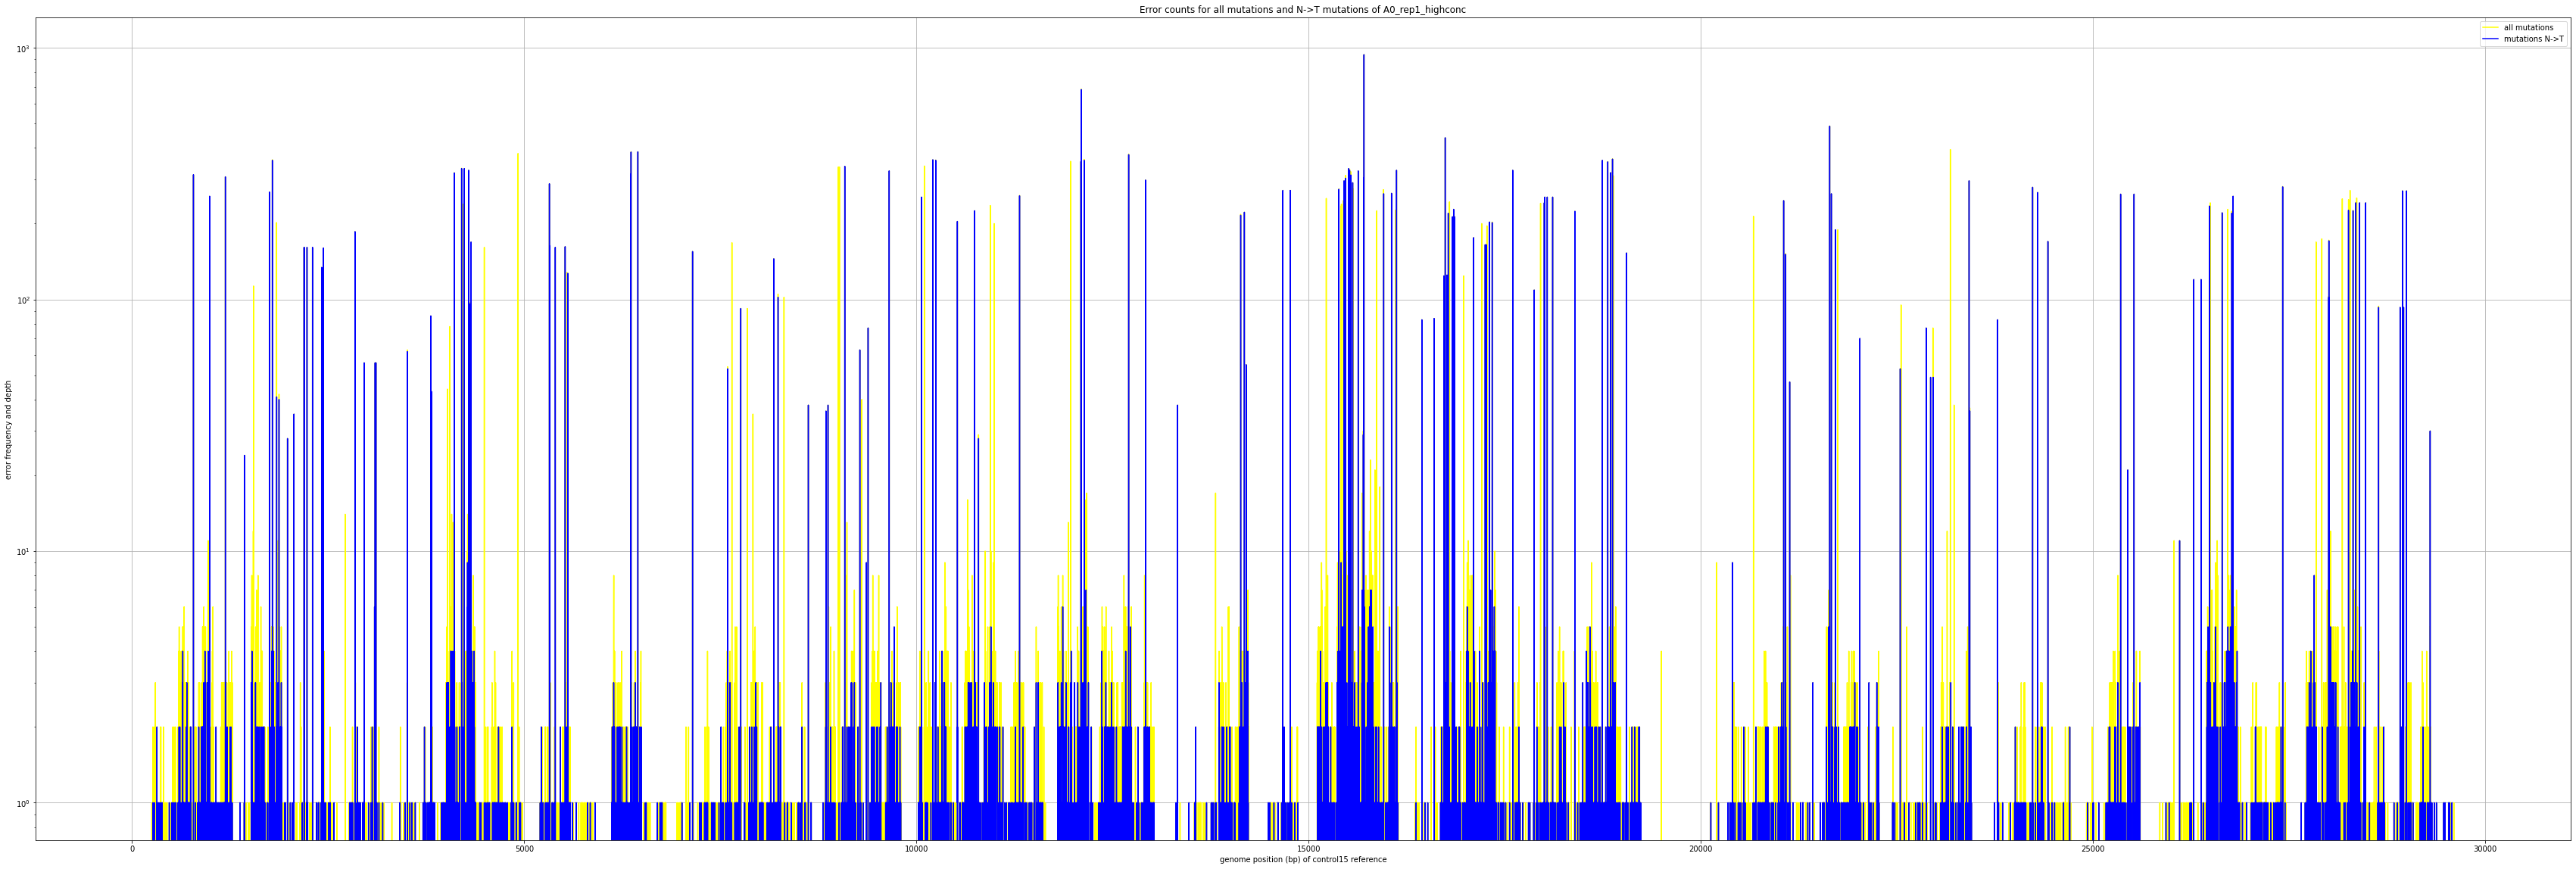

In [12]:
plt.figure(figsize=(60, 20))
plt.plot(df["POS"], df["ALT_COUNTS"], color="yellow")
plt.plot(df["POS"], df["MUT_TO_T"], color="blue")
#plt.plot(df["POS"], df["MUT_TO_A"], color="orange")
#plt.plot(df["POS"], df["MUT_TO_C"], color="red")
#plt.plot(df["POS"], df["MUT_TO_G"], color="green")

plt.title(f"Error counts for all mutations and N->T mutations of A{RATIO}_rep{REP}_{CONC}conc")
plt.xlabel(f"genome position (bp) of control{CONTROL} reference")
plt.ylabel("error frequency and depth")
plt.yscale('log')
plt.grid()
plt.legend(["all mutations", "mutations N->T"])

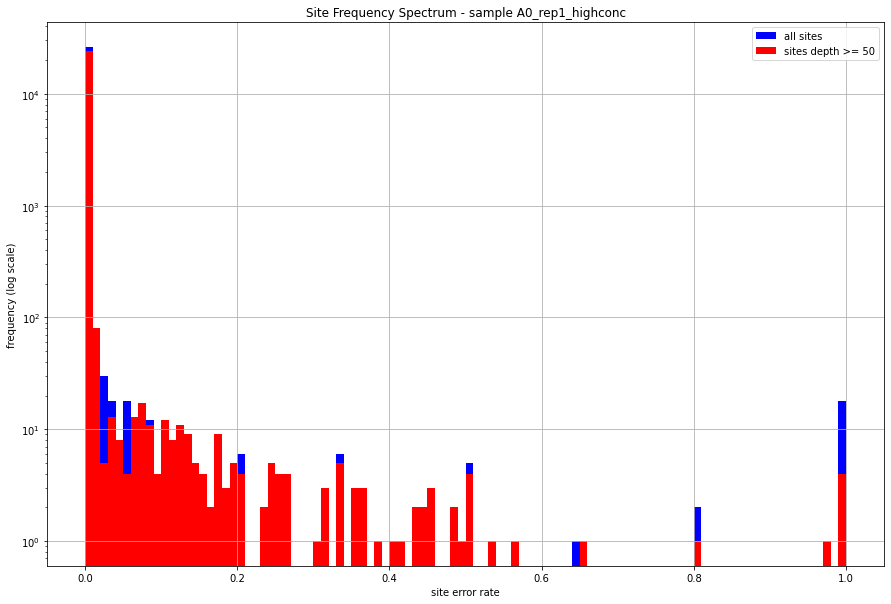

In [13]:
DEPTH=50
plt.figure(figsize=(15, 10))
plt.hist(df["ERROR_PC"], bins=100, color="blue")
plt.hist(df.where(df["DEPTH"] >=DEPTH)["ERROR_PC"], bins=100, color="red")

plt.yscale('log')
plt.grid()
plt.title(f'Site Frequency Spectrum - sample A{RATIO}_rep{REP}_{CONC}conc')
plt.xlabel('site error rate')
plt.ylabel('frequency (log scale)')
plt.legend(["all sites", f"sites depth >= {DEPTH}"]) #, "sites depth < 50"])

7629


Text(0, 0.5, 'count (number of sites)')

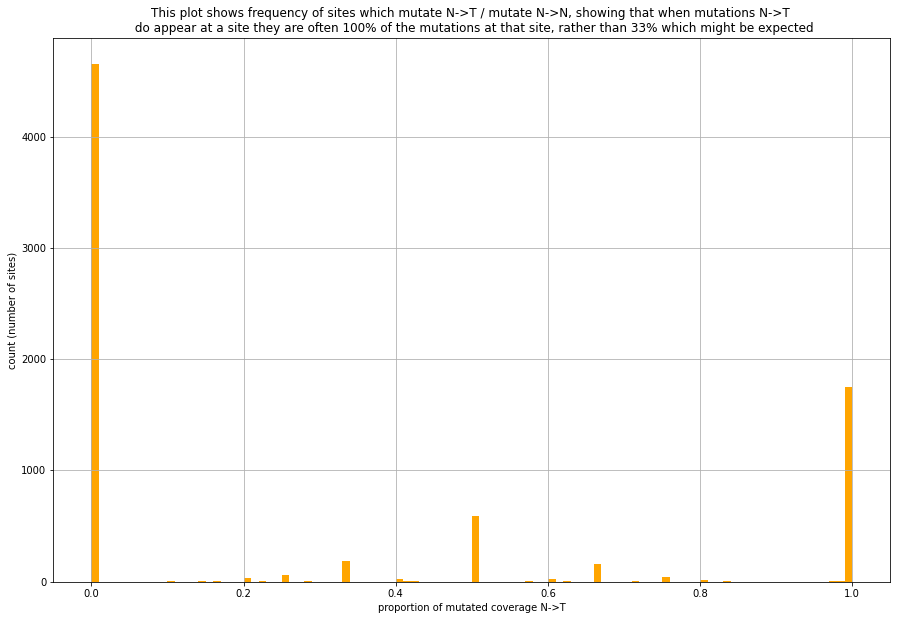

In [14]:
df2 = df.where(df["DEPTH"] >= 100).dropna().where(df["ALT_COUNTS"] > 0).dropna()
plt.figure(figsize=(15, 10))

#plt.hist(
#    df.apply(lambda x: max(x.MUT_TO_A, x.MUT_TO_C, x.MUT_TO_G, x.MUT_TO_T), axis=1)/df['ALT_COUNTS'],
#    bins=100, range=(0, 1), color="black")
#plt.hist(
#    df2['MUT_TO_A']/df2['ALT_COUNTS'],
#    bins=100, range=(0, 1), color="blue")
#plt.hist(
#    df2['MUT_TO_C']/df2['ALT_COUNTS'],
#    bins=100, range=(0, 1), color="red")

#plt.hist(
#    df2['MUT_TO_G']/df2['ALT_COUNTS'],
#    bins=100, range=(0, 1), color="green")
plt.hist(
    df2['MUT_TO_T']/df2['ALT_COUNTS'],
    bins=100, range=(0, 1), color="orange")

print(len(df2))
plt.grid()
plt.title("This plot shows frequency of sites which mutate N->T / mutate N->N, showing that when mutations N->T \n do appear at a site they are often 100% of the mutations at that site, rather than 33% which might be expected")
plt.xlabel("proportion of mutated coverage N->T")
plt.ylabel("count (number of sites)")

<ipython-input-15-97e2d0a065f8>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x2["TO_A_STOP"] = x1.apply(lambda x: int(x.A_STOP * x.COUNT_MUT_TO_A), axis=1)
<ipython-input-15-97e2d0a065f8>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x2["TO_C_STOP"] = x1.apply(lambda x: int(x.C_STOP * x.COUNT_MUT_TO_C), axis=1)
<ipython-input-15-97e2d0a065f8>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

,TO_A,TO_C,TO_G,TO_T
REF,,,,
A,0,9,6,15
C,3,0,3,36
G,10,5,0,98
N,0,0,0,0
T,1,14,2,0


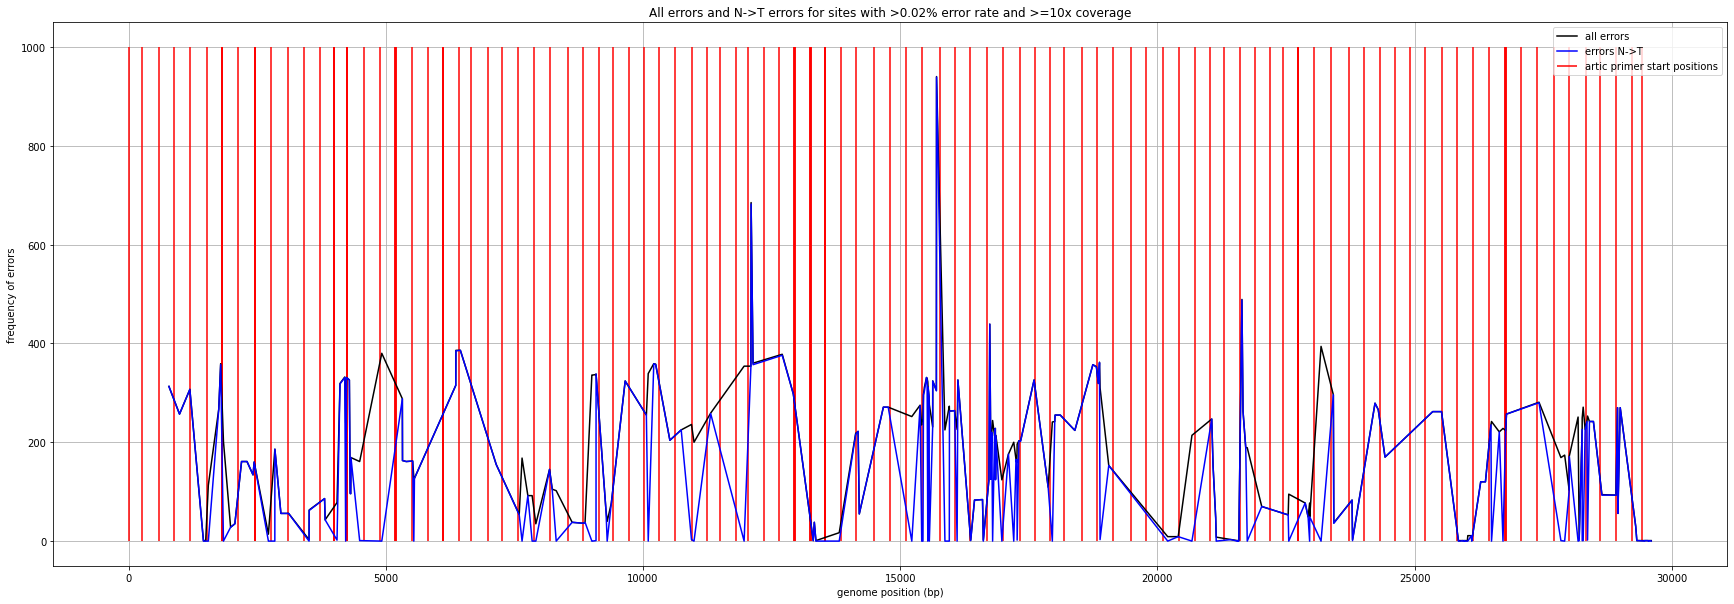

In [15]:
ERROR_CUTOFF = 0.02

x1 = df.where(df["ERROR_PC"] >= ERROR_CUTOFF).dropna().where(df["DEPTH"] >= 10).dropna()
plt.figure(figsize=(30, 10))
plt.title(f"All errors and N->T errors for sites with >{ERROR_CUTOFF}% error rate and >=10x coverage")
plt.plot(x1["POS"], x1["ALT_COUNTS"], color="black")
plt.plot(x1["POS"], x1["MUT_TO_T"], color="blue")
plt.vlines(ref_primers["start_x"], ymin=0, ymax=1000, color="red")
plt.xlabel("genome position (bp)")
plt.ylabel("frequency of errors")
plt.grid()
plt.legend(["all errors", "errors N->T", "artic primer start positions"])
x1["COUNT_MUT_TO_A"] = x1.apply(lambda y: 1 if y.MUT_TO_A/y.DEPTH > ERROR_CUTOFF and y.MUT_TO_A > 5 else 0 ,axis=1)
x1["COUNT_MUT_TO_C"] = x1.apply(lambda y: 1 if y.MUT_TO_C/y.DEPTH > ERROR_CUTOFF and y.MUT_TO_C > 5 else 0 ,axis=1)
x1["COUNT_MUT_TO_G"] = x1.apply(lambda y: 1 if y.MUT_TO_G/y.DEPTH > ERROR_CUTOFF and y.MUT_TO_G > 5 else 0 ,axis=1)
x1["COUNT_MUT_TO_T"] = x1.apply(lambda y: 1 if y.MUT_TO_T/y.DEPTH > ERROR_CUTOFF and y.MUT_TO_T > 5 else 0 ,axis=1)
x1["COUNT"] = 1
x1["A_STOP"] = x1.apply(lambda x: (1 if is_stop_codon(int(x['POS']), "A", ref_genome, ref_orf_starts, ref_orf_ends, ref_orf_frames) else 0), axis=1)
x1["C_STOP"] = x1.apply(lambda x: (1 if is_stop_codon(int(x['POS']), "C", ref_genome, ref_orf_starts, ref_orf_ends, ref_orf_frames) else 0), axis=1)
x1["G_STOP"] = x1.apply(lambda x: (1 if is_stop_codon(int(x['POS']), "G", ref_genome, ref_orf_starts, ref_orf_ends, ref_orf_frames) else 0), axis=1)
x1["T_STOP"] = x1.apply(lambda x: (1 if is_stop_codon(int(x['POS']), "T", ref_genome, ref_orf_starts, ref_orf_ends, ref_orf_frames) else 0), axis=1)

x2 = x1[["REF", "COUNT_MUT_TO_A", "COUNT_MUT_TO_C", "COUNT_MUT_TO_G", "COUNT_MUT_TO_T"]]
x2["TO_A_STOP"] = x1.apply(lambda x: int(x.A_STOP * x.COUNT_MUT_TO_A), axis=1)
x2["TO_C_STOP"] = x1.apply(lambda x: int(x.C_STOP * x.COUNT_MUT_TO_C), axis=1)
x2["TO_G_STOP"] = x1.apply(lambda x: int(x.G_STOP * x.COUNT_MUT_TO_G), axis=1)
x2["TO_T_STOP"] = x1.apply(lambda x: int(x.T_STOP * x.COUNT_MUT_TO_T), axis=1)
x2 = x2.groupby("REF").sum()
x2 = x2.rename(columns={"COUNT_MUT_TO_A":"TO_A", "COUNT_MUT_TO_C":"TO_C", "COUNT_MUT_TO_G":"TO_G", "COUNT_MUT_TO_T":"TO_T"})
x2[["TO_A", "TO_C", "TO_G", "TO_T"]]
# These sites (a total of 174 sites) have >= 10x Depth, >ERROR_CUTOFF% error rate, and I'm counting the number of times
# they mutate to a different allele in a 'significant' amount (significant means more than 5 mutations and
# more than ERROR_CUTOFF% of the total mutations)

,TO_A,TO_C,TO_G,TO_T
REF,,,,
A,0,725,1100,898
C,1125,0,241,747
G,692,257,0,1207
T,866,1204,691,0


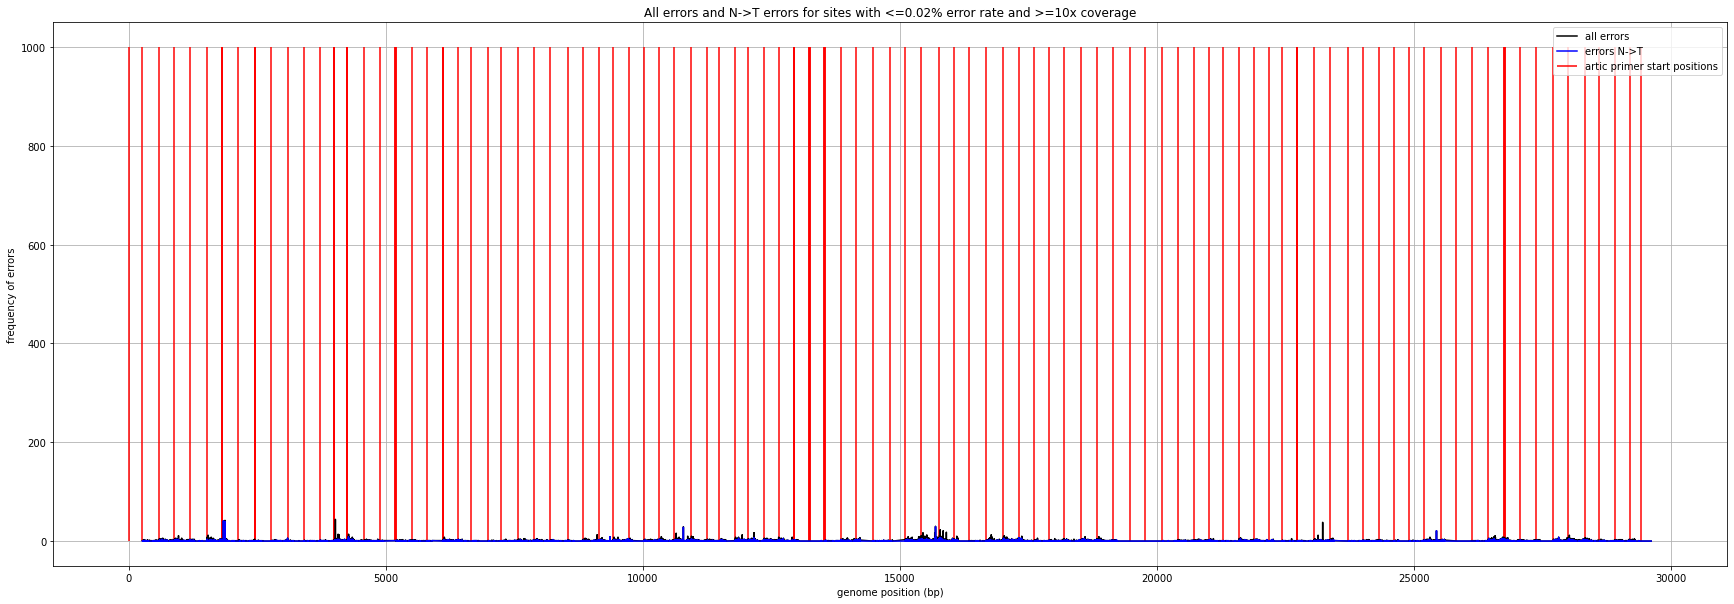

In [16]:
x3 = df.where(df["ERROR_PC"] < ERROR_CUTOFF).dropna().where(df["DEPTH"] >= 10).dropna()
x3["COUNT_MUT_TO_A"] = x3.apply(lambda y: 1 if y.MUT_TO_A > 0.01 else 0 ,axis=1)
x3["COUNT_MUT_TO_C"] = x3.apply(lambda y: 1 if y.MUT_TO_C > 0.01 else 0 ,axis=1)
x3["COUNT_MUT_TO_G"] = x3.apply(lambda y: 1 if y.MUT_TO_G > 0.01 else 0 ,axis=1)
x3["COUNT_MUT_TO_T"] = x3.apply(lambda y: 1 if y.MUT_TO_T > 0.01 else 0 ,axis=1)
x3["COUNT"] = 1
plt.figure(figsize=(30, 10))
plt.title(f"All errors and N->T errors for sites with <={ERROR_CUTOFF}% error rate and >=10x coverage")
plt.plot(x3["POS"], x3["ALT_COUNTS"], color="black")
plt.plot(x3["POS"], x3["MUT_TO_T"], color="blue")
plt.vlines(ref_primers["start_x"], ymin=0, ymax=1000, color="red")
plt.xlabel("genome position (bp)")
plt.ylabel("frequency of errors")
plt.grid()
plt.legend(["all errors", "errors N->T", "artic primer start positions"])
x4 = x3[["REF", "COUNT_MUT_TO_A", "COUNT_MUT_TO_C", "COUNT_MUT_TO_G", "COUNT_MUT_TO_T"]]
x4 = x4.rename(columns={"COUNT_MUT_TO_A":"TO_A", "COUNT_MUT_TO_C":"TO_C", "COUNT_MUT_TO_G":"TO_G", "COUNT_MUT_TO_T":"TO_T"})

x4.groupby("REF").sum()

#This time I am counting anything with an error rate < ERROR_CUTOFF% and >= 10x coverage

In [17]:
x3["A_STOP"] = x3.apply(lambda x: (1 if is_stop_codon(int(x['POS']), "A", ref_genome, ref_orf_starts, ref_orf_ends, ref_orf_frames) else 0), axis=1)

In [18]:
x3["C_STOP"] = x3.apply(lambda x: (1 if is_stop_codon(int(x['POS']), "C", ref_genome, ref_orf_starts, ref_orf_ends, ref_orf_frames) else 0), axis=1)
x3["G_STOP"] = x3.apply(lambda x: (1 if is_stop_codon(int(x['POS']), "G", ref_genome, ref_orf_starts, ref_orf_ends, ref_orf_frames) else 0), axis=1)
x3["T_STOP"] = x3.apply(lambda x: (1 if is_stop_codon(int(x['POS']), "T", ref_genome, ref_orf_starts, ref_orf_ends, ref_orf_frames) else 0), axis=1)

In [19]:
x4 = x3[["REF", "COUNT", "COUNT_MUT_TO_A", "COUNT_MUT_TO_C", "COUNT_MUT_TO_G", "COUNT_MUT_TO_T"]]
x4["TO_A_STOP"] = x3.apply(lambda x: x.A_STOP * x.COUNT_MUT_TO_A, axis=1)
x4["TO_C_STOP"] = x3.apply(lambda x: x.C_STOP * x.COUNT_MUT_TO_C, axis=1)
x4["TO_G_STOP"] = x3.apply(lambda x: x.G_STOP * x.COUNT_MUT_TO_G, axis=1)
x4["TO_T_STOP"] = x3.apply(lambda x: x.T_STOP * x.COUNT_MUT_TO_T, axis=1)
x4 = x4.groupby("REF").sum()
x4 = x4.rename(columns={"COUNT_MUT_TO_A":"TO_A", "COUNT_MUT_TO_C":"TO_C", "COUNT_MUT_TO_G":"TO_G", "COUNT_MUT_TO_T":"TO_T"})
x4

<ipython-input-19-e3d5d7a69093>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x4["TO_A_STOP"] = x3.apply(lambda x: x.A_STOP * x.COUNT_MUT_TO_A, axis=1)
<ipython-input-19-e3d5d7a69093>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x4["TO_C_STOP"] = x3.apply(lambda x: x.C_STOP * x.COUNT_MUT_TO_C, axis=1)
<ipython-input-19-e3d5d7a69093>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

,COUNT,TO_A,TO_C,TO_G,TO_T,TO_A_STOP,TO_C_STOP,TO_G_STOP,TO_T_STOP
REF,,,,,,,,,
A,7647,0,725,1100,898,0,0,0,48
C,4668,1125,0,241,747,93,0,15,44
G,4973,692,257,0,1207,44,0,0,157
T,8256,866,1204,691,0,82,0,18,0


In [20]:
df["IN_PRIMER"] = df.apply(lambda x: in_site(x.POS, primer_starts, primer_ends), axis=1)
x5 = df.where(
    df["ERROR_PC"] >= ERROR_CUTOFF).dropna().where(df["DEPTH"] >= 10).dropna()

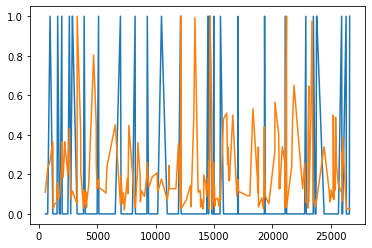

In [21]:
plt.plot(x5["IN_PRIMER"])
plt.plot(x5["ERROR_PC"])

In [22]:
def to_primer(row):
    
    if not row.IN_PRIMER:
        return -1
    
    primer_row = ref_primers.where(
        ((ref_primers["start_x"] <= int(row.POS)) & (ref_primers["end_x"] >= int(row.POS))) | 
        ((ref_primers["start_y"] <= int(row.POS)) & (ref_primers["end_y"] >= int(row.POS)))).dropna()
    

    a = list((primer_row["start_x"] <= int(row.POS)) & (primer_row["end_x"] >= int(row.POS)))
    #print(a)
    if a[0]:
        #print(list(primer_row.left_sequence)[0])
        #print(list(primer_row.start_x)[0])
        primer_nucleotide = list(primer_row.left_sequence)[0][int(row.POS - list(primer_row.start_x)[0] - 1)]
    
    else:
        #print(list(primer_row.right_sequence)[0])
        #print(list(primer_row.start_y)[0], row.POS)
        primer_nucleotide = list(primer_row.right_sequence)[0][int(row.POS - list(primer_row.start_y)[0] - 1)]
    
    mutated_nucleotide = row.REF
    
    rowmax = max(int(row.MUT_TO_A), int(row.MUT_TO_C), int(row.MUT_TO_G), int(row.MUT_TO_T))
    
    if int(row.MUT_TO_A) == rowmax:
        mutated_nucleotide = "A"
    elif int(row.MUT_TO_C) == rowmax:
        mutated_nucleotide = "C"
    elif int(row.MUT_TO_G) == rowmax:
        mutated_nucleotide = "G"
    elif int(row.MUT_TO_T) == rowmax:
        mutated_nucleotide = "T"
        
    if primer_nucleotide == mutated_nucleotide:
        return 1
    
    else:
        return 0

In [23]:
df2 = df[df["IN_PRIMER"]].where(df["ALT_COUNTS"] > 0).dropna()
df2["TO_PRIMER"] = df2.apply(lambda x: to_primer(x), axis=1)

In [24]:
ref_primers

,genome_x,amplicon_number,is_alt_x,is_alt_y,start_x,end_x,start_y,end_y,left_sequence,right_sequence
0,MN908947.3,1,False,False,15,39,332,356,AACGAACTTTAAAATCTGTGTGGC,GAGGCACGTCAACATCTTAAAGAT
1,MN908947.3,2,False,False,267,289,651,673,CTGTTTTACAGGTTCGCGACGT,ACGAGCTTGGCACTGATCCTTA
2,MN908947.3,3,False,False,589,611,951,973,CGGTAATAAAGGAGCTGGTGGC,AGAGCTATGAATTGCAGACACC
3,MN908947.3,4,False,False,890,912,1259,1281,GGTGTATACTGCTGCCGTGAAC,ACTAAAGAAGGTGCCACTACTT
4,MN908947.3,5,False,False,1189,1211,1570,1592,TGGTGAAACTTCATGGCAGACG,ACTCCAAAAAGAGAAAGTCAAC
...,...,...,...,...,...,...,...,...,...,...
126,MN908947.3,94,False,False,28323,28345,28685,28707,GGCCCCAAGGTTTACCCAATAA,CCTCAAGGAACAACATTGCCAA
127,MN908947.3,95,False,False,28606,28628,28970,28992,TGAGGGAGCCTTGAATACACCA,AAGCCTCGGCAAAAACGTACTG
128,MN908947.3,96,False,False,28914,28936,29285,29307,GCCAACAACAACAAGGCCAAAC,ACATTCCCACCAACAGAGCCTA
129,MN908947.3,97,False,False,29217,29245,29594,29622,TGGATGACAAAGATCCAAATTTCAAAGA,CTCACATAGCAATCTTTAATCAGTGTGT


In [25]:
df2[["REF", "IN_PRIMER" ,"TO_PRIMER"]].groupby("REF").sum()

,IN_PRIMER,TO_PRIMER
REF,,
A,560.0,138
C,544.0,143
G,548.0,172
T,594.0,124
